In [1]:
import sys, glob, io, os
from PIL import Image, ImageOps
import numpy as np
from PIL import ImageFont
import matplotlib.pyplot as plt
from scipy.misc import imresize
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import torch.nn as nn
from torchvision.utils import save_image

from get_data.font2img import draw_single_char, draw_example, draw_handwriting
from get_data.package import pickle_examples
from common.utils import centering_image, denorm_image, normalize_image, add_padding, tight_crop_image
from common.dataset import TrainDataProvider, save_fixed_sample
from common.function import init_embedding

## 내 손글씨 데이터셋 생성!!

### 먼저 써야 할 245가지 글자 선정

In [9]:
charset_11172 = []
for char in range(int('AC00', 16), int('D7A4', 16)):
    charset_11172.append(chr(char))
print(len(charset_11172))
print(charset_11172[:5], '~', charset_11172[-5:])

11172
['가', '각', '갂', '갃', '간'] ~ ['힟', '힠', '힡', '힢', '힣']


In [10]:
file_path = './get_data/2350-common-hangul.txt'
with open(file_path) as f:
    charset_2350 = f.read().split('\n')
charset_2350 = charset_2350[:-1]
print(len(charset_2350))
print(charset_2350[:5], '~', charset_2350[-5:])

2350
['가', '각', '간', '갇', '갈'] ~ ['힐', '힘', '힙', '힛', '힝']


In [11]:
# charset_245 = list(np.random.choice(charset_2350, 145, replace=False))
# charset_245 = charset_245 + list(np.random.choice(charset_11172, 100, replace=False))
# charset_245 = list(set(charset_245))
# charset_245.sort()
# print(len(charset_245))
# print(charset_245)

In [12]:
charset_210 = ['겅', '겆', '겜', '겯', '궓', '기', '긽', '꺷', '꺾', '껙', '꽁', '꽍', '꾶', '꿀', \
               '꿋', '뀀', '뀻', '끎', '끕', '낳', '냄', '냱', '넧', '넨', '놋', '놨', '놰', '뇔', \
               '뇹', '늡', '닑', '댽', '뎬', '돎', '됷', '둠', '뒣', '듀', '듬', '땀', '땋', '뗶', \
               '뚦', '뛒', '뛰', '뜸', '띔', '랖', '램', '럤', '렝', '련', '렵', '렽', '롯', '롷', \
               '롼', '뢋', '룡', '룩', '뤇', '륑', '륨', '륿', '릙', '릞', '링', '맷', '먛', '멈', \
               '멱', '멼', '몴', '뫴', '뭏', '뭣', '뭻', '뮴', '바', '밝', '뱝', '벋', '봃', '뵂', \
               '뵐', '뵨', '불', '붻', '뺍', '뺐', '뺙', '뽮', '뾏', '쀭', '삘', '삥', '사', '색', \
               '샛', '솎', '솰', '숌', '숭', '싀', '싇', '식', '싫', '싱', '싹', '쌤', '쎻', '쏞', \
               '쏫', '쐬', '쑕', '쑹', '씀', '앃', '앍', '압', '얌', '얹', '얼', '얽', '엔', '옆', \
               '예', '옫', '왓', '욉', '욧', '워', '웬', '윑', '유', '윩', '읓', '잡', '잿', '쟎', \
               '정', '젯', '졎', '존', '죽', '줊', '중', '쥐', '쥿', '즢', '즶', '짓', '짘', '짠', \
               '쨋', '쮪', '쯓', '찝', '착', '챤', '챨', '첂', '첺', '쳰', '초', '촤', '쵒', '쵕', \
               '축', '춫', '췽', '츯', '컫', '켓', '쾀', '쿰', '퀵', '큭', '탭', '턉', '텝', '톕', \
               '톤', '툼', '튠', '트', '틂', '틥', '펨', '퐁', '퐱', '푐', '푻', '퓐', '플', '핢', \
               '핥', '험', '혤', '홉', '확', '홴', '횳', '훗', '휊', '휩', '휴', '흥', '흫', '힙']
len(charset_210)

210

### user의 root_path 생성

In [13]:
user_name = 'jeina'
root_path = './handwritings/%s' % user_name
if not os.path.exists(root_path):
    os.mkdir(root_path)

### Handwriting pdfs

In [14]:
handwriting_path = 'handwritings/210_%s_handwriting.jpg' % user_name
handwriting_path

'handwritings/210_jeina_handwriting.jpg'

In [15]:
handwriting = Image.open(handwriting_path).convert('L')
handwriting = handwriting.crop(box=(74, 81, 2099, 2981))
print(handwriting.size)

chars = []
for i in range(14):
    row = handwriting.crop(box=(0, i*207+74, 2025, (i+1)*207-3))
    for j in range(15):
        char = row.crop(box=(j*135+3, 3, (j+1)*135-3, 125))
        char = char.resize((128, 128))
        char = np.array(char)
        char = normalize_image(char)
        round_function = lambda i: 1 if i > 0.96 else i
        char = np.array(list(map(round_function, char.flatten()))).reshape(128, 128)
#         char = tight_crop_image(char)
#         h, w = char.shape
#         char = imresize(char, (int(h * 1.3), int(w * 1.3)))
#         char = normalize_image(char)
#         char = add_padding(char, pad_value=1)
        char = centering_image(char)
        chars.append(char)
len(chars)

(2025, 2900)


210

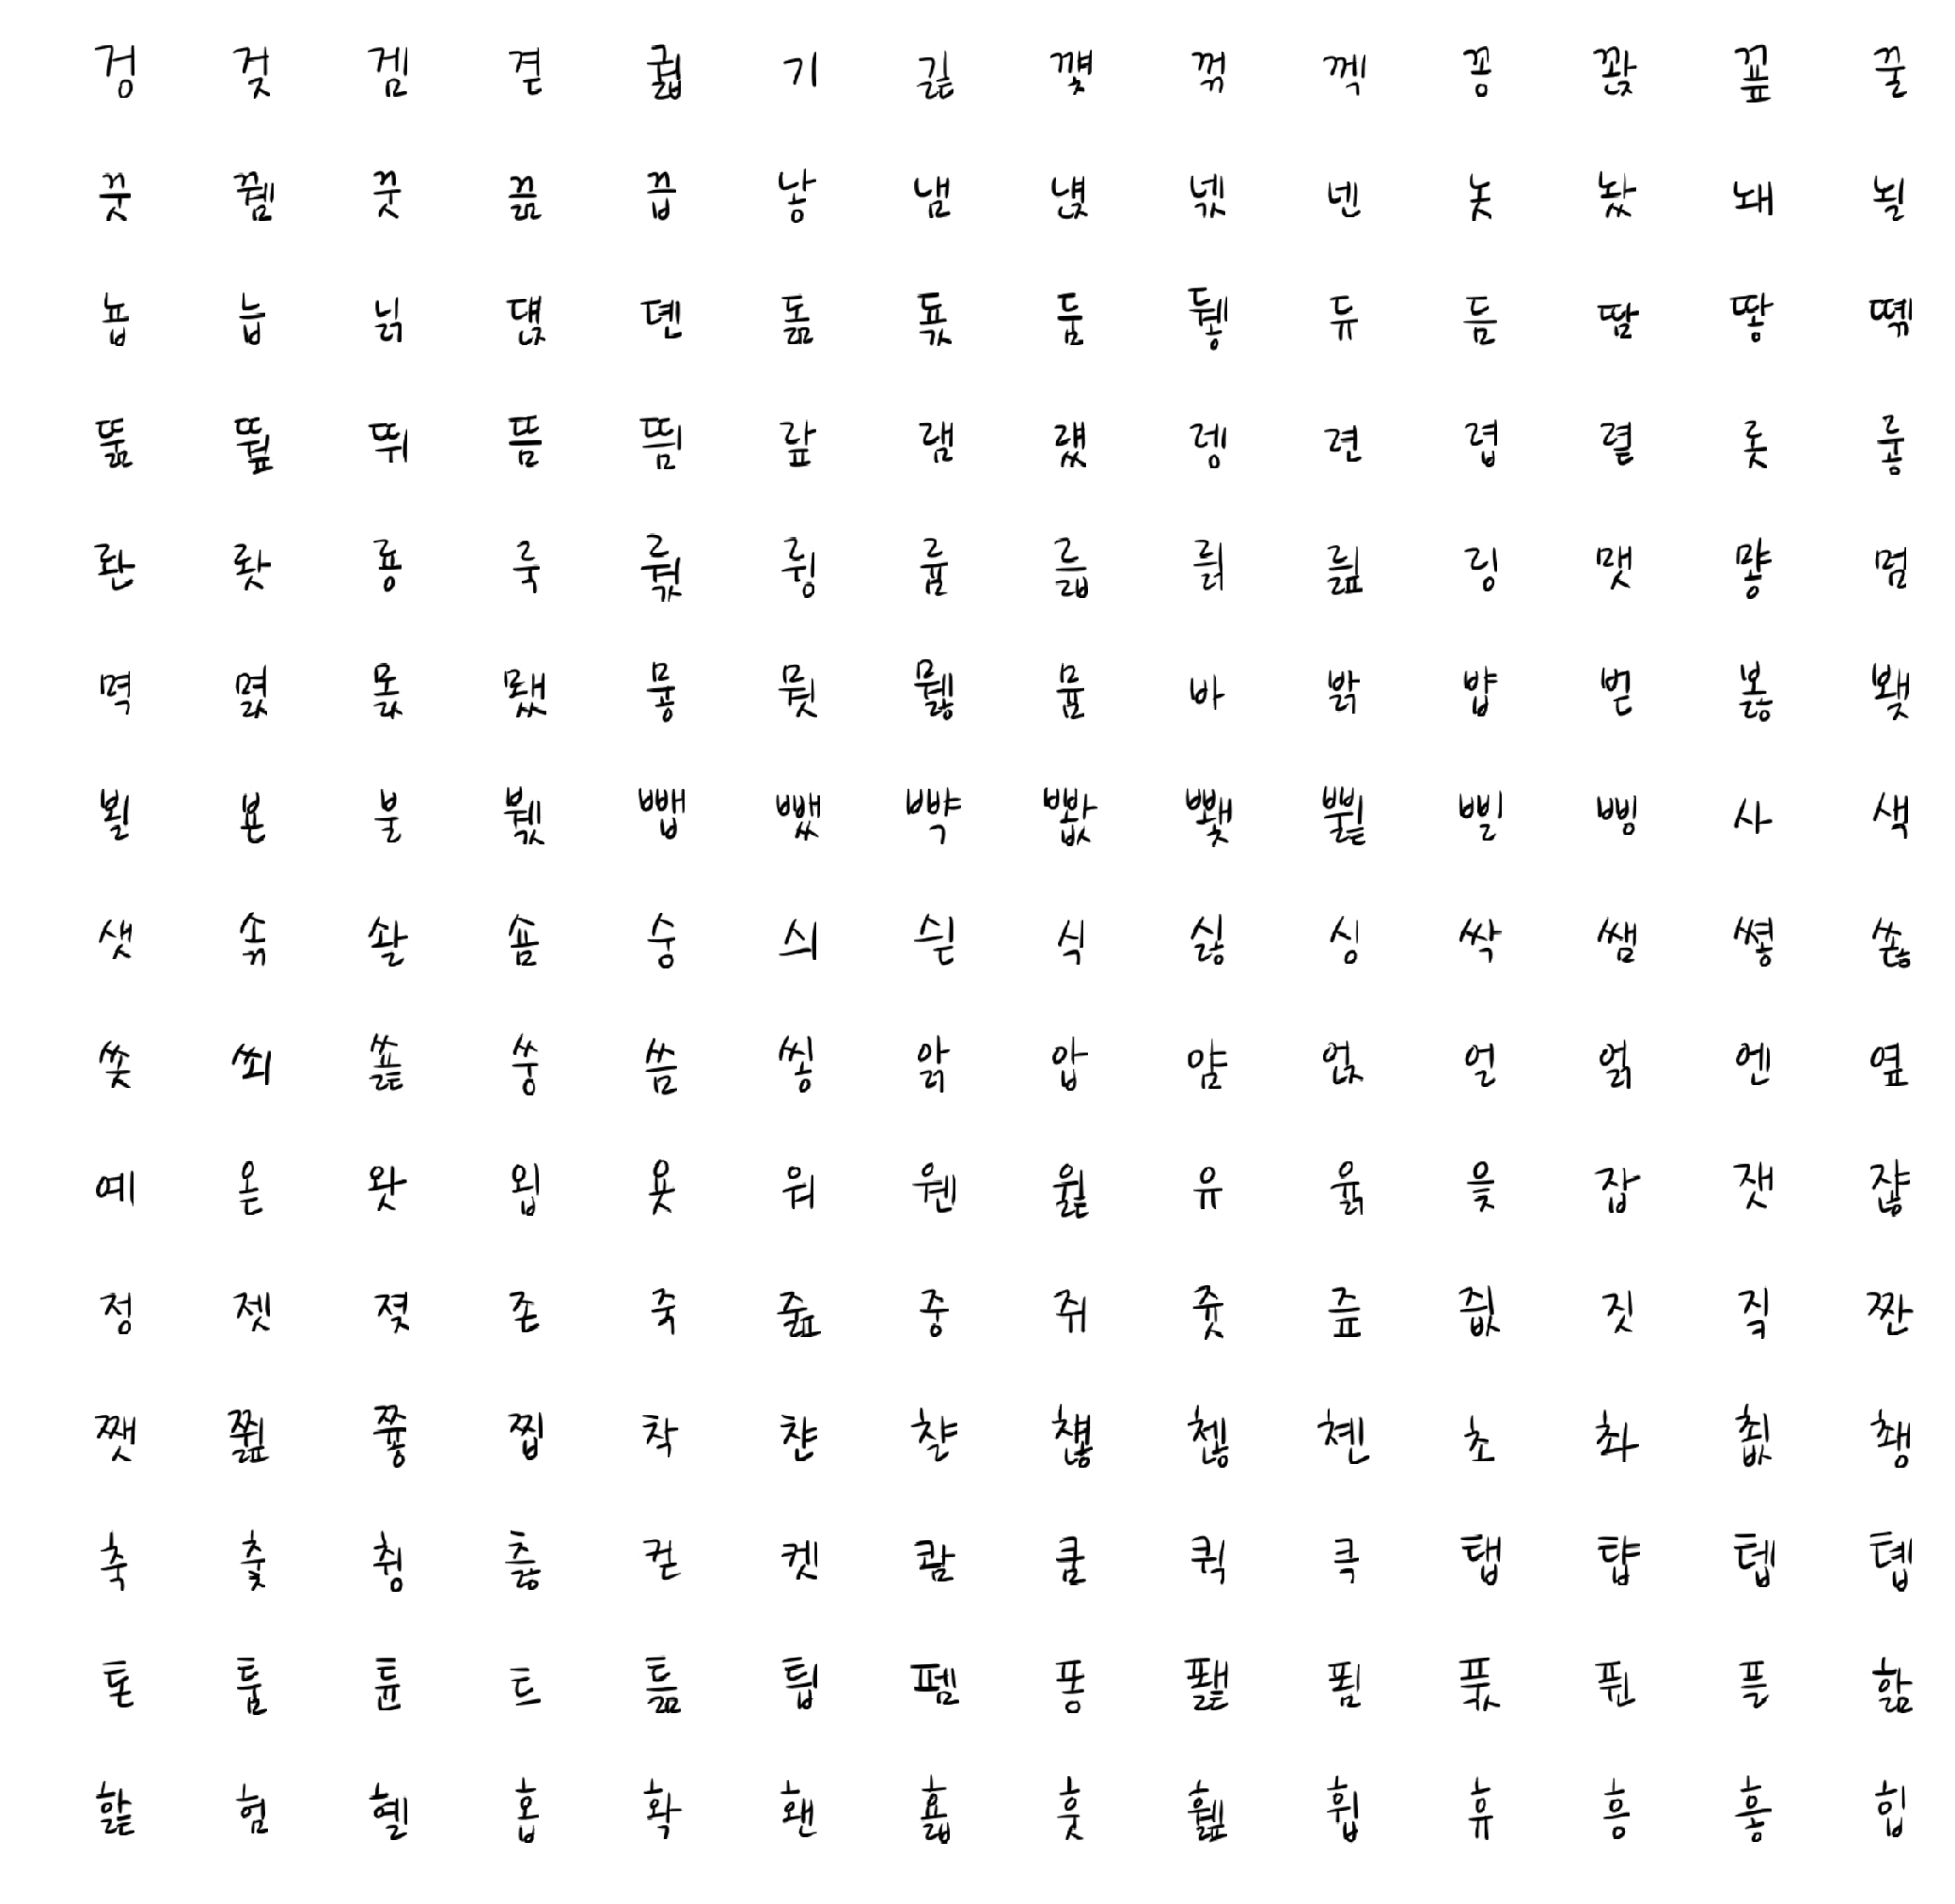

In [30]:
plt.figure(figsize=(18, 18))
for idx, char in enumerate(chars):
    plt.subplot(15, 14, idx+1)
    plt.imshow(char, cmap='gray')
    plt.axis('off')
plt.show()

- 데이터 생성 TEST - 두 글자 (target font, source font) 이미지 생성

### png파일로 저장 - `jeina_pngs`

In [9]:
handwriting = Image.open(handwriting_path).convert('L')
handwriting = handwriting.crop(box=(74, 81, 2099, 2981))
print(handwriting.size)

chars = []
for i in range(14):
    row = handwriting.crop(box=(0, i*207+74, 2025, (i+1)*207-3))
    for j in range(15):
        char = row.crop(box=(j*135+3, 3, (j+1)*135-3, 125))
        char = char.resize((128, 128))
        chars.append(char)
len(chars)

(2025, 2900)


210

In [32]:
count = 0
font_label = 0
canvas_size = 128
src_char_size = 90

save_path = os.path.join(root_path, '%s_pngs/' % user_name)
if not os.path.exists(save_path):
    os.mkdir(save_path)
    
for idx, char in enumerate(chars):
    char = char.convert('L')
    charid = charset_11172.index(charset_210[idx])
    char.save(os.path.join(save_path, "%d_%04d.png" % (font_label, charid)))
    count += 1
    if count % 50 == 0:
        print("processed %d chars" % count)
font_label += 1
print("processed %d chars, end" % count)

processed 50 chars
processed 100 chars
processed 150 chars
processed 200 chars
processed 210 chars, end


### src_font와 함께 있는 이미지로 저장 -`jeina_210chars`

In [33]:
SRC_PATH = './get_data/fonts/source/'
src_font = glob.glob(os.path.join(SRC_PATH, '*.ttf'))[0]
src_font = ImageFont.truetype(src_font, size=src_char_size)
src_font

In [34]:
count = 0
font_label = 0
canvas_size = 128
src_char_size = 90

save_path = os.path.join(root_path, '%s_210chars/' % user_name)
from_path = os.path.join(root_path, '%s_pngs/' % user_name)
if not os.path.exists(save_path):
    os.mkdir(save_path)

for idx, char in enumerate(chars):
    c = charset_210[idx]
    charid = charset_11172.index(c)
    e = draw_handwriting(c, src_font, canvas_size, from_path, font_label, charid)
    if e:
        e.save(os.path.join(save_path, "%d_%04d.png" % (font_label, charid)))
        count += 1
    if count % 50 == 0:
        print("%d font: processed %d chars" % (font_label, count))
print("processed %d chars, end" % count)

0 font: processed 50 chars
0 font: processed 100 chars
0 font: processed 150 chars
0 font: processed 200 chars
processed 210 chars, end


In [35]:
save_path = os.path.join(root_path, '%s_210chars/' % user_name)
datasets = glob.glob(os.path.join(save_path, '*.png'))
print(len(datasets))
datasets[-5:]

210


['./handwritings/jeina/jeina_210chars/0_0560.png',
 './handwritings/jeina/jeina_210chars/0_3044.png',
 './handwritings/jeina/jeina_210chars/0_7421.png',
 './handwritings/jeina/jeina_210chars/0_8597.png',
 './handwritings/jeina/jeina_210chars/0_4761.png']

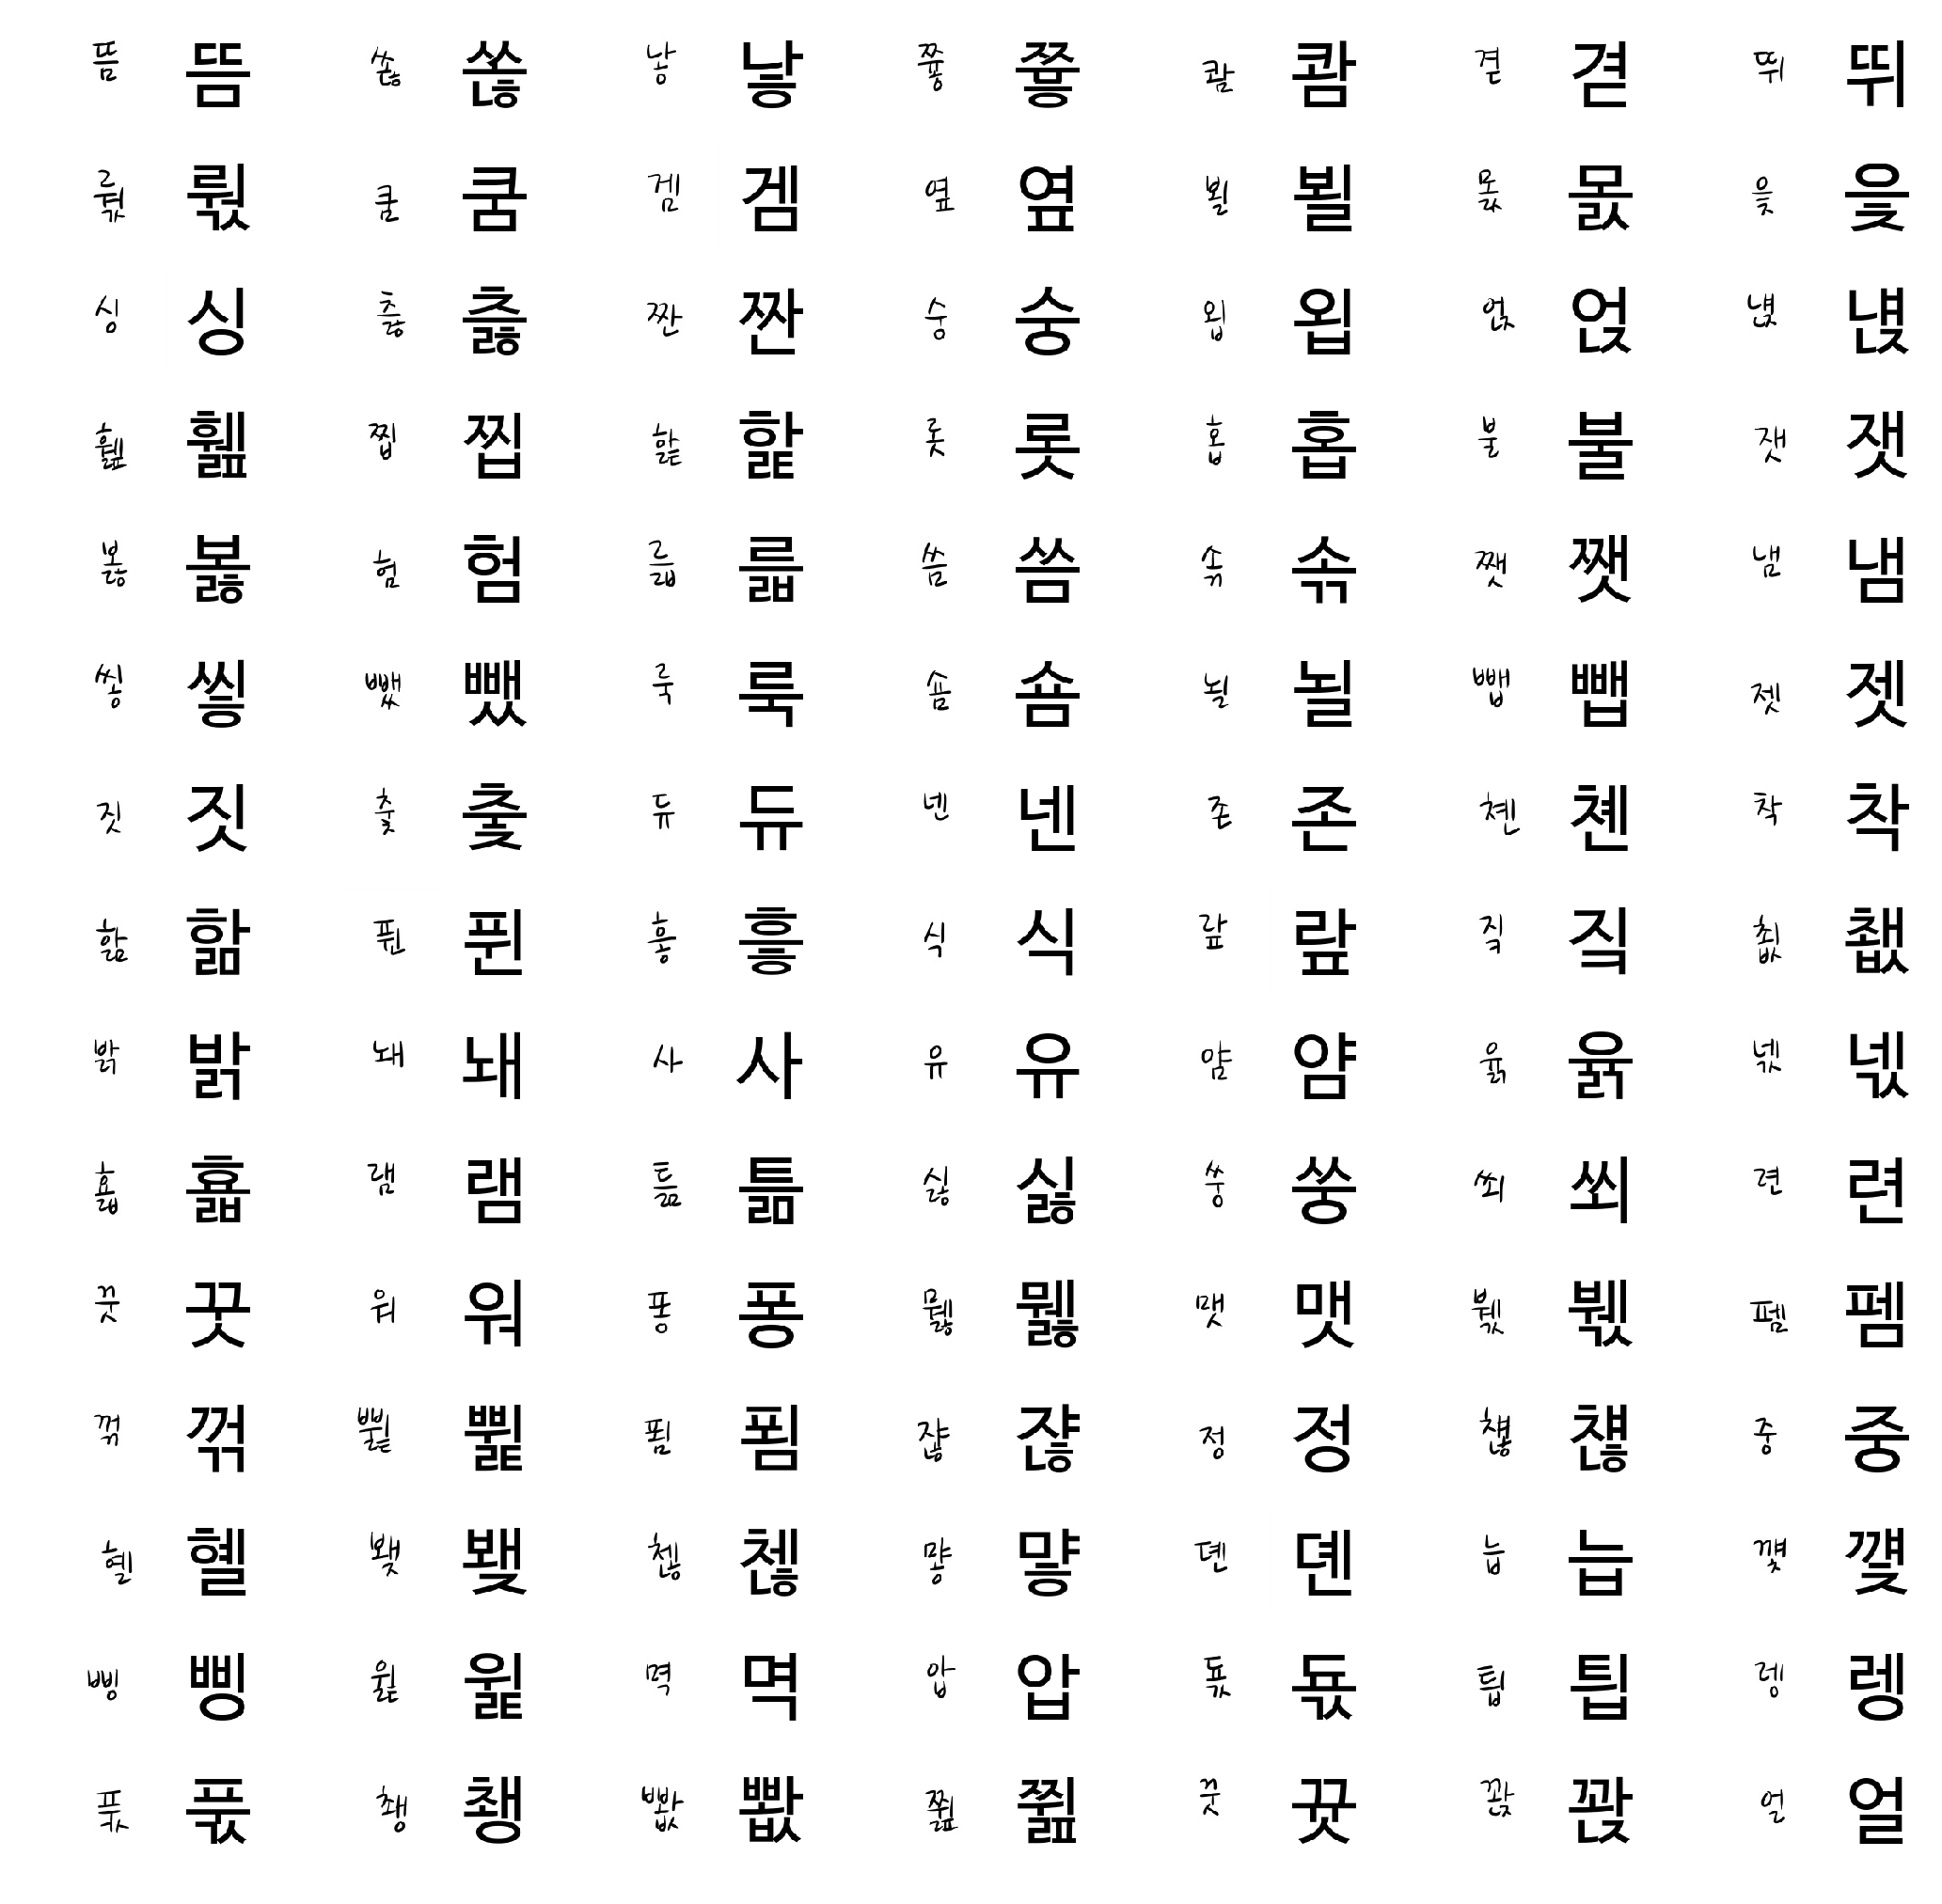

In [9]:
plt.figure(figsize=(18, 18))
for idx, png in enumerate(datasets[:105]):
    img = Image.open(png).convert('L')
    plt.subplot(15, 7, idx+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

### `package.py`로 obj 파일 생성

In [13]:
from_dir = os.path.join(root_path, '%s_210chars/' % user_name)
save_dir = os.path.join(root_path, '%s_dataset/' % user_name)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    
train_path = os.path.join(save_dir, "train.obj")
val_path = os.path.join(save_dir, "val.obj")

pickle_examples(from_dir, train_path=train_path, val_path=val_path, \
                train_val_split=0, with_charid=True)

all data num: 210
pickle with charid
0 imgs saved in val.obj, end
210 imgs saved in train.obj, end


- 210자 데이터 생성 완료!

## Fixed Samples

In [16]:
sample_size = 24
img_size = 128

data_dir = os.path.join(root_path, '%s_dataset/' % user_name)
save_dir = os.path.join(root_path, '%s_fixed_sample/' % user_name)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

save_fixed_sample(sample_size, img_size, data_dir, save_dir, resize_fix=1.3)

unpickled total 210 examples
train examples -> 210


In [17]:
fixed_source = torch.load(os.path.join(save_dir, 'fixed_source.pkl'))
fixed_target = torch.load(os.path.join(save_dir, 'fixed_target.pkl'))
fixed_label = torch.load(os.path.join(save_dir, 'fixed_label.pkl'))

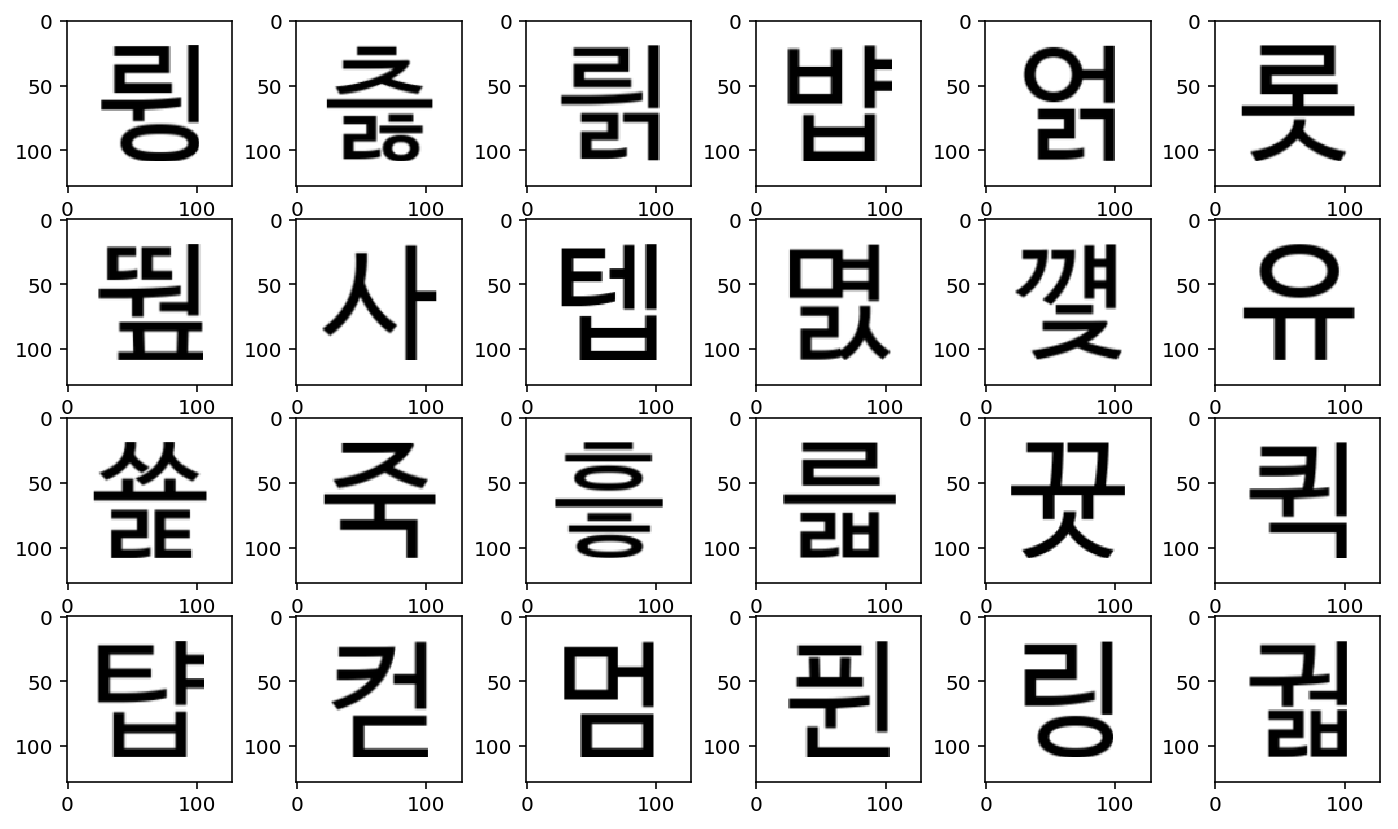

In [18]:
plt.figure(figsize=(12, 7))
for idx, image in enumerate(fixed_source):
    plt.subplot(4, 6, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().numpy(), cmap='gray')
plt.show()

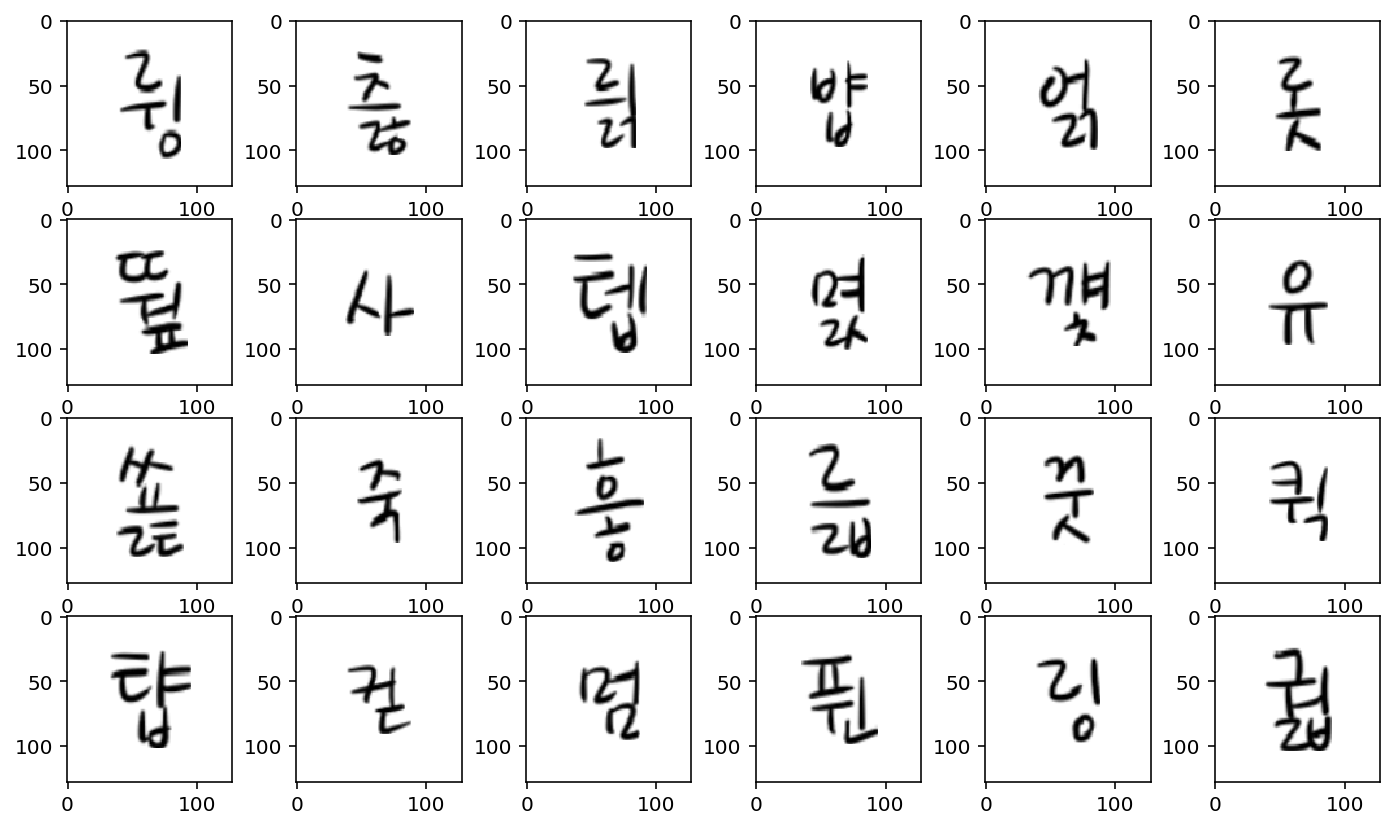

In [19]:
plt.figure(figsize=(12, 7))
for idx, image in enumerate(fixed_target):
    plt.subplot(4, 6, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().numpy(), cmap='gray')
plt.show()

#### Fake Target만 저장

In [20]:
save_path = os.path.join(root_path, '%s_fixed_fake/' % user_name)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    
save_image(denorm_image(fixed_target.data), \
           os.path.join(save_path, '0_%s_Ground_truth_target.png' % user_name), \
           nrow=6, pad_value=255)